# MM compare log analysis
Set `run_id` to the directory under `log/` you want to inspect (e.g., `test_seed1`, `test_seed2`).

Loads the summary log, fundamental path, order book (if available), and samples of agent logs for the single market maker, ZI, HBL, value, and momentum cohorts.

## Optional: run simulation from notebook


In [102]:
import subprocess
from pathlib import Path
run_simulation = True  # set True to launch
seed = 85
ticker = 'AAPL'
historical_date = '20000101'
start_time = '09:30:00'
end_time = '16:00:00'
mm_type = 'simple'  # or simple/adaptive/spread/rl_baseline
log_prefix = 'notebook_run'
run_id = f"{log_prefix}_seed{seed}"
log_dir = Path('..') / 'log' / run_id
if run_simulation:
    cmd = [
        'python', 'abides.py',
        '-c', 'mm_compare',
        '-t', ticker,
        '-d', historical_date,
        '--start-time', start_time,
        '--end-time', end_time,
        '--seed', str(seed),
        '--log_dir', run_id,
        '--mm-type', mm_type,
    ]
    print('Running:', ' '.join(cmd))
    result = subprocess.run(cmd, cwd=Path('..'))
    print('Return code:', result.returncode)
else:
    print('Skipping simulation run; set run_simulation=True to execute.')
# point analysis to this run_id
log_dir = Path('..') / 'log' / run_id
print('Using log_dir', log_dir)


Running: python abides.py -c mm_compare -t AAPL -d 20000101 --start-time 09:30:00 --end-time 16:00:00 --seed 85 --log_dir notebook_run_seed85 --mm-type simple
ABIDES: Agent-Based Interactive Discrete Event Simulation

Simulation Start Time: 2025-12-01 13:58:58.800628
Configuration seed: 85


--- Simulation time: 2000-01-01 00:00:00, messages processed: 0, wallclock elapsed: 0 days 00:00:00.000010 ---

Final holdings for Value Agent 1: { AAPL: 1699, CASH: -162345795 }.  Marked to market: 11917237
Final holdings for Value Agent 2: { AAPL: 2774, CASH: -270473433 }.  Marked to market: 14050199
Final holdings for Value Agent 3: { AAPL: 4248, CASH: -420543095 }.  Marked to market: 15165769
Final holdings for Value Agent 4: { AAPL: 1064, CASH: -97945349 }.  Marked to market: 11187003
Final holdings for Value Agent 5: { AAPL: 2605, CASH: -251795573 }.  Marked to market: 15394067
Final holdings for MARKET_MAKER_AGENT_0: { AAPL: -12390, CASH: 1263103245 }.  Marked to market: -7714275
Logging ord

Processing orderbook log: 100%|██████████| 12882/12882 [00:00<00:00, 42966.81it/s]


Order book logging complete!
Time taken to log the order book: 0:00:00.860071
Order book archival complete.
Event Queue elapsed: 0 days 00:00:04.391970, messages: 99047, messages per second: 22551.8
Mean ending value by agent type:
ValueAgent: 3542855
MarketMakerAgent: -17714275
Simulation ending!
Simulation End Time: 2025-12-01 13:59:04.672946
Time taken to run simulation: 0:00:05.872318
Return code: 0
Using log_dir ../log/notebook_run_seed85


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

# Change this to point to a different log directory (relative to the repo root)
print('Log dir:', log_dir.resolve())
sorted(log_dir.iterdir())[:10]

Log dir: /Users/salim/Desktop/Columbia/Assignments_Columbia/S3/Reinforcement Learning/Project/ABIDES/abides/log/notebook_run_seed85


[PosixPath('../log/notebook_run_seed85/EXCHANGE_AGENT.bz2'),
 PosixPath('../log/notebook_run_seed85/MARKET_MAKER_AGENT_0.bz2'),
 PosixPath('../log/notebook_run_seed85/ORDERBOOK_AAPL_FULL.bz2'),
 PosixPath('../log/notebook_run_seed85/ValueAgent1.bz2'),
 PosixPath('../log/notebook_run_seed85/ValueAgent2.bz2'),
 PosixPath('../log/notebook_run_seed85/ValueAgent3.bz2'),
 PosixPath('../log/notebook_run_seed85/ValueAgent4.bz2'),
 PosixPath('../log/notebook_run_seed85/ValueAgent5.bz2'),
 PosixPath('../log/notebook_run_seed85/fundamental_AAPL.bz2'),
 PosixPath('../log/notebook_run_seed85/summary_log.bz2')]

## Summary log

In [104]:
summary = pd.read_pickle(log_dir / 'summary_log.bz2')
wide_summary = (
    summary
    .pivot_table(index=['AgentID', 'AgentStrategy'], columns='EventType', values='Event', aggfunc='first')
)
wide_summary['PNL'] = wide_summary['ENDING_CASH'] - wide_summary['STARTING_CASH']
wide_summary.reset_index().head(20)

EventType,AgentID,AgentStrategy,ENDING_CASH,FINAL_CASH_POSITION,FINAL_VALUATION,STARTING_CASH,PNL
0,1,ValueAgent,11917237.0,-1.623458e+08,-17.058759,10000000.0,1917237.0
1,2,ValueAgent,14050199.0,-2.704734e+08,-27.757756,10000000.0,4050199.0
2,3,ValueAgent,15165769.0,-4.205431e+08,-42.619929,10000000.0,5165769.0
3,4,ValueAgent,11187003.0,-9.794535e+07,-10.680768,10000000.0,1187003.0
4,5,ValueAgent,15394067.0,-2.517956e+08,-25.910655,10000000.0,5394067.0
5,6,MarketMakerAgent,-7714275.0,1.263103e+09,NaN,10000000.0,-17714275.0


In [88]:
# Aggregate PnL by agent strategy
strategy_pnl = wide_summary.groupby(level=1)['PNL'].sum().sort_values(ascending=False)
strategy_pnl.to_frame('PNL')

,PNL
AgentStrategy,
MarketMakerAgent,898461.0
ValueAgent,-898461.0


In [89]:
# Top/bottom PnL by individual agent
wide_summary.reset_index().sort_values('PNL', ascending=False).head(10)

EventType,AgentID,AgentStrategy,ENDING_CASH,FINAL_CASH_POSITION,FINAL_VALUATION,STARTING_CASH,PNL
4,5,ValueAgent,12196099.0,79032944.0,6.836570,10000000.0,2196099.0
5,6,MarketMakerAgent,10898461.0,108150361.0,NaN,10000000.0,898461.0
3,4,ValueAgent,10660027.0,20289872.0,1.019455,10000000.0,660027.0
0,1,ValueAgent,10533332.0,-7010148.0,-1.681951,10000000.0,533332.0
2,3,ValueAgent,8161185.0,-33981305.0,-4.360003,10000000.0,-1838815.0
1,2,ValueAgent,7550896.0,-106481724.0,-11.533788,10000000.0,-2449104.0


In [64]:
# Market maker PnL slice
mm_summary = (
    wide_summary.reset_index()
    .query("AgentStrategy.str.contains('MarketMaker')", engine='python')
    .sort_values('PNL', ascending=False)
)
mm_summary[['AgentID', 'AgentStrategy', 'PNL']].head(10)

EventType,AgentID,AgentStrategy,PNL


## Fundamental path

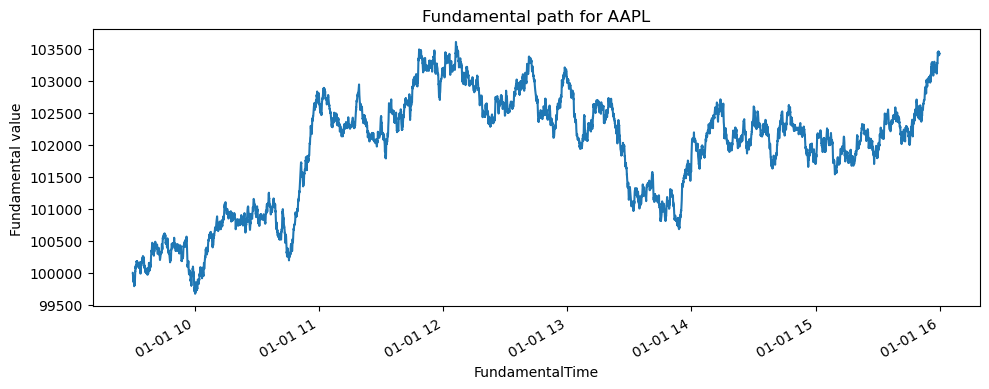

In [105]:
# Derive ticker from ORDERBOOK filename (e.g., ORDERBOOK_AAPL_FULL.bz2)
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'))
ticker = orderbook_file.name.split('_')[1]

fundamental_path = log_dir / f'fundamental_{ticker}.bz2'
fundamental = pd.read_pickle(fundamental_path).reset_index()

fundamental.plot(x='FundamentalTime', y='FundamentalValue', legend=False, figsize=(10, 4))
plt.ylabel('Fundamental value')
plt.title(f'Fundamental path for {ticker}')
plt.tight_layout()

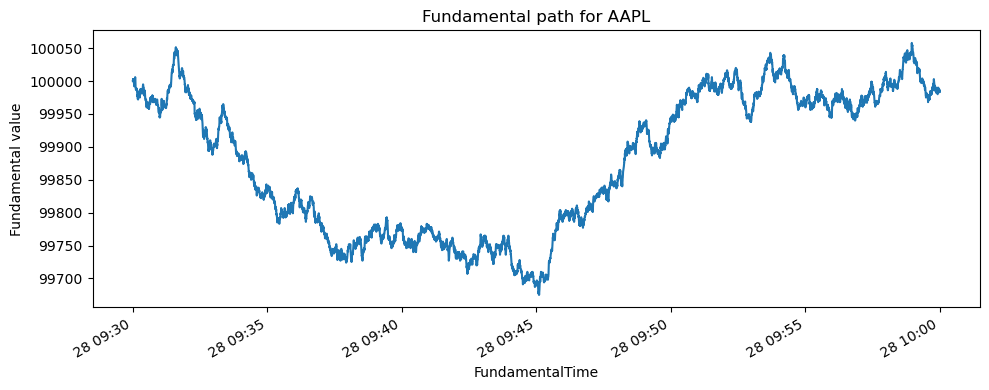

In [66]:
# Derive ticker from ORDERBOOK filename (e.g., ORDERBOOK_AAPL_FULL.bz2)
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'))
ticker = orderbook_file.name.split('_')[1]

fundamental_path = log_dir / f'fundamental_{ticker}.bz2'
fundamental = pd.read_pickle(fundamental_path).reset_index()

fundamental.plot(x='FundamentalTime', y='FundamentalValue', legend=False, figsize=(10, 4))
plt.ylabel('Fundamental value')
plt.title(f'Fundamental path for {ticker}')
plt.tight_layout()

## Order book (top of book)

If the order book log includes best bid/ask price columns, the cell below will extract and plot mid/spread. Otherwise it shows the available columns so you can adapt.

In [67]:
orderbook = pd.read_pickle(orderbook_file)
print('Orderbook columns:', list(orderbook.columns))

# Heuristic search for best bid/ask price columns
def find_col(columns, substrings):
    for col in columns:
        name = ' '.join(col) if isinstance(col, tuple) else str(col)
        lname = name.lower()
        if all(sub in lname for sub in substrings):
            return col
    return None

bid_price_col = find_col(orderbook.columns, ['best', 'bid']) or find_col(orderbook.columns, ['bid', 'price'])
ask_price_col = find_col(orderbook.columns, ['best', 'ask']) or find_col(orderbook.columns, ['ask', 'price'])

if bid_price_col and ask_price_col:
    top = orderbook[[bid_price_col, ask_price_col]].copy()
    top.columns = ['best_bid_price', 'best_ask_price']
    top['mid'] = (top['best_bid_price'] + top['best_ask_price']) / 2
    top['spread'] = top['best_ask_price'] - top['best_bid_price']
    ax = top[['mid']].plot(figsize=(10, 4), title='Mid price')
    plt.tight_layout()
    ax = top[['spread']].plot(figsize=(10, 3), title='Quoted spread')
    plt.tight_layout()
else:
    display(orderbook.head())

Orderbook columns: [99411, 99469, 99480, 99507, 99567, 99570, 99626, 99632, 99645, 99657, 99663, 99665, 99666, 99673, 99675, 99679, 99680, 99686, 99688, 99695, 99698, 99699, 99700, 99705, 99707, 99708, 99709, 99710, 99711, 99714, 99715, 99716, 99717, 99718, 99719, 99720, 99721, 99722, 99723, 99724, 99725, 99726, 99727, 99728, 99729, 99730, 99731, 99732, 99733, 99734, 99735, 99736, 99737, 99738, 99739, 99740, 99741, 99742, 99743, 99744, 99745, 99746, 99747, 99748, 99749, 99750, 99751, 99752, 99753, 99754, 99755, 99756, 99757, 99758, 99759, 99760, 99761, 99762, 99763, 99764, 99765, 99766, 99767, 99768, 99769, 99770, 99771, 99772, 99773, 99774, 99775, 99776, 99777, 99778, 99779, 99780, 99781, 99782, 99783, 99784, 99785, 99786, 99787, 99788, 99789, 99790, 99791, 99792, 99793, 99794, 99795, 99796, 99797, 99798, 99799, 99800, 99801, 99802, 99803, 99804, 99805, 99806, 99807, 99808, 99809, 99810, 99811, 99812, 99813, 99814, 99815, 99816, 99817, 99818, 99819, 99820, 99821, 99822, 99823, 99824, 

,99411,99469,99480,99507,99567,99570,99626,99632,99645,99657,...,100134,100143,100153,100165,100166,100183,100201,100203,100209,100224
QuoteTime,,,,,,,,,,,,,,,,,,,,,
2019-06-28 09:30:00.000025866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-28 09:30:00.000080456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-28 09:30:00.000101215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-28 09:30:00.000104161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-28 09:30:00.000116222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Agent logs

Helper to load any agent log, then example slices for a market maker, ZI, HBL, value, and momentum agent. Adjust filenames as needed.

In [68]:
def load_agent_log(filename):
    return pd.read_pickle(log_dir / filename)

all_agents = sorted(
    f.name for f in log_dir.glob('*.bz2')
    if 'summary' not in f.name and 'ORDERBOOK' not in f.name and 'fundamental' not in f.name
)
print('Total agent logs:', len(all_agents))
all_agents[:10]

Total agent logs: 5201


['EXCHANGE_AGENT.bz2',
 'HBL_AGENT_5151.bz2',
 'HBL_AGENT_5152.bz2',
 'HBL_AGENT_5153.bz2',
 'HBL_AGENT_5154.bz2',
 'HBL_AGENT_5155.bz2',
 'HBL_AGENT_5156.bz2',
 'HBL_AGENT_5157.bz2',
 'HBL_AGENT_5158.bz2',
 'HBL_AGENT_5159.bz2']

In [69]:
# Market maker example (single MM)
mm_files = [f for f in all_agents if 'MARKET_MAKER' in f]
if mm_files:
    mm_log = load_agent_log(mm_files[0])
    display(mm_log.head())
    print('Columns:', list(mm_log.columns))
else:
    print('No market maker logs found')

No market maker logs found


In [70]:
# Zero Intelligence agent example
zi_files = [f for f in all_agents if 'ZI_AGENT' in f]
if zi_files:
    zi_log = load_agent_log(zi_files[0])
    display(zi_log.head())
else:
    print('No ZI agent logs found')

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,ZeroIntelligenceAgent
NaT,STARTING_CASH,10000000
2019-06-28 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2019-06-28 09:30:00.008595382,BID_DEPTH,"[(100047, 48)]"
2019-06-28 09:30:00.008595382,ASK_DEPTH,"[(100097, 40)]"


In [71]:
# Heuristic Belief Learning agent example
hbl_files = [f for f in all_agents if 'HBL_AGENT' in f]
if hbl_files:
    hbl_log = load_agent_log(hbl_files[0])
    display(hbl_log.head())
else:
    print('No HBL agent logs found')

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,HeuristicBeliefLearningAgent
NaT,STARTING_CASH,10000000
2019-06-28 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2019-06-28 09:30:00.001390636,BID_DEPTH,"[(99953, 1414)]"
2019-06-28 09:30:00.001390636,ASK_DEPTH,"[(100097, 100)]"


In [72]:
# Value agent example
value_files = [f for f in all_agents if 'ValueAgent' in f]
if value_files:
    value_log = load_agent_log(value_files[0])
    display(value_log.head())
else:
    print('No value agent logs found')

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,ValueAgent
NaT,STARTING_CASH,10000000
2019-06-28 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2019-06-28 09:30:00.013728148,BID_DEPTH,"[(99953, 2021)]"
2019-06-28 09:30:00.013728148,ASK_DEPTH,"[(99958, 6)]"


In [73]:
# Momentum agent example
momentum_files = [f for f in all_agents if 'MOMENTUM_AGENT' in f]
if momentum_files:
    momentum_log = load_agent_log(momentum_files[0])
    display(momentum_log.head())
else:
    print('No momentum agent logs found')

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,MomentumAgent
NaT,STARTING_CASH,10000000
2019-06-28 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2019-06-28 09:30:20.018982598,BID_DEPTH,"[(99982, 71)]"
2019-06-28 09:30:20.018982598,ASK_DEPTH,"[(99983, 80)]"


## Optional: Mark-to-market trajectory for the market maker

If the MM log contains `Holdings`, `Cash`, and a price column (`MidPrice`/`LastPrice`), the helper below will compute and plot running mark-to-market PnL.

In [74]:
def plot_mm_mark_to_market(mm_df):
    colmap = {c.lower(): c for c in mm_df.columns}
    cash_col = colmap.get('cash')
    holdings_col = colmap.get('holdings') or colmap.get('inventory')
    price_col = colmap.get('midprice') or colmap.get('mid_price') or colmap.get('lastprice') or colmap.get('last_price')
    time_col = colmap.get('time') or colmap.get('timestamp')

    needed = [cash_col, holdings_col, price_col, time_col]
    if any(c is None for c in needed):
        print('Missing columns for mark-to-market:', needed)
        return

    pnl = mm_df[cash_col] + mm_df[holdings_col] * mm_df[price_col]
    plot_df = pd.DataFrame({
        'time': mm_df[time_col],
        'mark_to_market': pnl
    }).set_index('time')
    plot_df.plot(title='Market maker mark-to-market', figsize=(10, 4))
    plt.tight_layout()

# Example usage (uncomment after confirming columns above)
# if mm_files:
#     plot_mm_mark_to_market(mm_log)

## Inventory and spread over time

### Inventory and spread plotting options


In [75]:
# Optional manual overrides for plotting
manual_inventory_file = None  # e.g., 'RL_MARKET_MAKER_AGENT_0.bz2'
manual_inventory_column = None  # e.g., 'inventory'
manual_time_column = None  # e.g., 'time'
manual_orderbook_bid_col = None  # e.g., ('best_bid_price')
manual_orderbook_ask_col = None  # e.g., ('best_ask_price')


In [76]:
# Plot agent inventory (best-effort)
agent_with_inv = None
state_from_events = None
# If manual override provided, use it
if manual_inventory_file is not None:
    df = pd.read_pickle(log_dir / manual_inventory_file)
    inv_col = manual_inventory_column
    time_col = manual_time_column
    agent_with_inv = (manual_inventory_file, df, inv_col, time_col)
else:
    for fname in all_agents:
        df = pd.read_pickle(log_dir / fname)
        # Try STATE events if present (e.g., RL agent)
        if 'EventType' in df.columns and 'Event' in df.columns:
            states = df[df['EventType'] == 'STATE']
            if not states.empty:
                ev_df = pd.DataFrame(list(states['Event']))
                if 'inventory' in ev_df.columns:
                    state_from_events = ev_df
                    agent_with_inv = ('STATE_EVENTS', ev_df, 'inventory', 'time' if 'time' in ev_df.columns else ev_df.index.name)
                    break
        cols = {c.lower(): c for c in df.columns}
        inv_col = cols.get('holdings') or cols.get('inventory')
        time_col = cols.get('time') or cols.get('timestamp') or df.index.name
        if inv_col is not None:
            agent_with_inv = (fname, df, inv_col, time_col)
            break
if agent_with_inv:
    fname, df, inv_col, time_col = agent_with_inv
    print('Inventory plot from', fname)
    if state_from_events is not None:
        df_plot = state_from_events.copy()
        if time_col and time_col in df_plot.columns:
            df_plot = df_plot.set_index(time_col)
        df_plot['inventory'].plot(figsize=(10,3), title=f'Inventory over time ({fname})', legend=True, label='inventory')
    else:
        if time_col is None:
            df = df.reset_index()
            time_col = df.columns[0]
        df_plot = df[[time_col, inv_col]].copy().set_index(time_col)
        df_plot[inv_col].plot(figsize=(10,3), title=f'Inventory over time ({fname})', legend=True, label=inv_col)
    plt.tight_layout()
else:
    print('No agent log with inventory/holdings column found. Available columns:')
    if all_agents:
        sample_cols = {f: list(pd.read_pickle(log_dir / f).columns)[:10] for f in all_agents[:3]}
        print(sample_cols)
    else:
        print('No agent logs found')

# Plot spread over time from orderbook
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'), None)
if orderbook_file:
    ob = pd.read_pickle(orderbook_file)
    def find_col(columns, substrings):
        for col in columns:
            name = ' '.join(col) if isinstance(col, tuple) else str(col)
            lname = name.lower()
            if all(sub in lname for sub in substrings):
                return col
        return None
    bid_price_col = manual_orderbook_bid_col if manual_orderbook_bid_col is not None else (find_col(ob.columns, ['best', 'bid']) or find_col(ob.columns, ['bid', 'price']))
    ask_price_col = manual_orderbook_ask_col if manual_orderbook_ask_col is not None else (find_col(ob.columns, ['best', 'ask']) or find_col(ob.columns, ['ask', 'price']))
    if bid_price_col is None or ask_price_col is None:
        print('Could not find best bid/ask in orderbook log. Columns sample:', list(ob.columns)[:10])
    else:
        top = ob[[bid_price_col, ask_price_col]].copy()
        top.columns = ['best_bid_price', 'best_ask_price']
        top['spread'] = top['best_ask_price'] - top['best_bid_price']
        top['spread'].plot(figsize=(10,3), title='Spread over time', legend=True, label='spread')
        plt.tight_layout()
else:
    print('Orderbook file not found')


No agent log with inventory/holdings column found. Available columns:
{'EXCHANGE_AGENT.bz2': ['EventType', 'Event'], 'HBL_AGENT_5151.bz2': ['EventType', 'Event'], 'HBL_AGENT_5152.bz2': ['EventType', 'Event']}
Could not find best bid/ask in orderbook log. Columns sample: [99411, 99469, 99480, 99507, 99567, 99570, 99626, 99632, 99645, 99657]
